In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
from fastai.data import load

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import *

from models.utils.joiner2 import Joiner
from models.utils.new_losses import *
from models.utils.metrics import Accuracy
from models.utils.dataLoader import *
from models.utils.datasets import CustomCifar

from collections import defaultdict, deque
import itertools
import matplotlib.pyplot as plt
import numpy as np

from numba import jit, cuda
from timeit import default_timer as timer

In [2]:
import webdataset as wds

In [3]:
torch.cuda.set_device("cuda:3")

In [4]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [5]:
H = 256
W= 256
bs=5
#size = 1000

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
class CustomImageNet(datasets.ImageNet):
    def __init__(self, path, transforms, width=256, height=256, patch_size = 32, map_width = 256, map_height = 256, grid_l=1, pf="1",size=None, start_idx = 0, train=True):
        super().__init__(path)
        self.width = width
        self.height = height
        self.patch_size = patch_size
        self.map_width = map_width
        self.map_height = map_height
        self.grid_l = grid_l
        self.pf = pf
        self.transforms = transforms
        self.train = train
        self.start_time = time.time()
        if size == None:
            if train == True:
                self.size = 1000000
            else:
                self.size = 200000
        else:
            self.size = size
        self.start_idx = start_idx
        self.indexes = self.create_idx()
        self.attention_mask = Curating_of_attention_mask(self.patch_size, self.width, self.height, self.map_width, self.map_height, self.grid_l, self.pf)
        self.pattn_dict = self.create_labels()

    def new_empty(self):
        
        return ()

    def create_idx(self):
        indexes = {}
        for i in range(self.size):
            indexes[i] = i+ self.start_idx

        return indexes
    
    def create_labels(self):
        
        transform = T.Compose([
        T.Resize((self.height,self.width)),
        T.ToTensor()
        ])
        
        attention_labels = {}
        for i in range(len(self.indexes)):
            index = self.indexes[i]
            im, _ = super().__getitem__(index)
            pattn = self.attention_mask(self.transforms(im))
            attention_labels[i] = pattn
            
            if i%50 == 0:
                time_elapsed = time.time() - self.start_time
                print('{} images complete in {:.0f}m {:.0f}s'.format(i, time_elapsed // 60, time_elapsed % 60))
                #self.start_time = time.time()
            
        return attention_labels

    def __len__(self):
         return len(self.indexes)
        
    def __getitem__(self, index):

        #index = self.indexes[index]
        im, label = super().__getitem__(self.indexes[index])
        pattn = self.pattn_dict[index]
        return self.transforms(im),(pattn,label)

In [7]:
#ds_train = CifarDataset(path_train, path_val=None, transforms=transform, start_idx = 40)

In [8]:
#file_name = "len"+str(10000)+"_startIdx"+str(40)
#torch.save(ds_train, 'data/GramCifar/train/train_CustomCifar'+file_name+'.tar')

In [9]:
#ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#len(ds)

In [10]:
class AssembleDataset(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        
    def forward(self, size, start_idx):
        ds_train = CustomImageNet(path='./data', transforms=transform, patch_size = 32, size= size, start_idx=start_idx, train=False)
        return ds_train

In [11]:
dataset = AssembleDataset()
dataset = dataset.to(device)

In [12]:
size = 1000
max_size = 1000
max_size_list = []
for i in range(0,max_size+1,size):
    max_size_list.append(i)
max_size_list

[0, 1000]

In [16]:
start = timer()
#for s in max_size_list:
ds_train = dataset(1000000,0)
file_name = '_32x32GridLabel_1million_images'#+str(s)
#torch.save(ds_train, 'test.tar')
torch.save(ds_train, 'data/GramImageNet/train/val_CustomImageNet'+file_name+'.tar')
print("Total time:", timer()-start) 

0 images complete in 0m 0s
50 images complete in 0m 7s
100 images complete in 0m 13s
150 images complete in 0m 21s
200 images complete in 0m 28s
250 images complete in 0m 34s
300 images complete in 0m 42s
350 images complete in 0m 48s
400 images complete in 0m 55s
450 images complete in 1m 2s
500 images complete in 1m 9s
550 images complete in 1m 16s
600 images complete in 1m 23s
650 images complete in 1m 30s
700 images complete in 1m 36s
750 images complete in 1m 43s
800 images complete in 1m 50s
850 images complete in 1m 57s
900 images complete in 2m 4s
950 images complete in 2m 11s
1000 images complete in 2m 18s
1050 images complete in 2m 25s
1100 images complete in 2m 32s
1150 images complete in 2m 39s
1200 images complete in 2m 46s
1250 images complete in 2m 53s
1300 images complete in 3m 0s
1350 images complete in 3m 8s
1400 images complete in 3m 15s
1450 images complete in 3m 22s
1500 images complete in 3m 29s
1550 images complete in 3m 36s
1600 images complete in 3m 43s
1650 im

13000 images complete in 30m 35s
13050 images complete in 30m 42s
13100 images complete in 30m 49s
13150 images complete in 30m 56s
13200 images complete in 31m 3s
13250 images complete in 31m 10s
13300 images complete in 31m 17s
13350 images complete in 31m 24s
13400 images complete in 31m 31s
13450 images complete in 31m 37s
13500 images complete in 31m 44s
13550 images complete in 31m 51s
13600 images complete in 31m 58s
13650 images complete in 32m 5s
13700 images complete in 32m 12s
13750 images complete in 32m 19s
13800 images complete in 32m 25s
13850 images complete in 32m 32s
13900 images complete in 32m 39s
13950 images complete in 32m 46s
14000 images complete in 32m 53s
14050 images complete in 32m 60s
14100 images complete in 33m 6s
14150 images complete in 33m 13s
14200 images complete in 33m 20s
14250 images complete in 33m 27s
14300 images complete in 33m 34s
14350 images complete in 33m 41s
14400 images complete in 33m 49s
14450 images complete in 33m 56s
14500 images 

25500 images complete in 60m 29s
25550 images complete in 60m 36s
25600 images complete in 60m 44s
25650 images complete in 60m 51s
25700 images complete in 60m 59s
25750 images complete in 61m 6s
25800 images complete in 61m 13s
25850 images complete in 61m 21s
25900 images complete in 61m 28s
25950 images complete in 61m 35s
26000 images complete in 61m 43s
26050 images complete in 61m 50s
26100 images complete in 61m 58s
26150 images complete in 62m 5s
26200 images complete in 62m 13s
26250 images complete in 62m 20s
26300 images complete in 62m 27s
26350 images complete in 62m 34s
26400 images complete in 62m 41s
26450 images complete in 62m 48s
26500 images complete in 62m 55s
26550 images complete in 63m 2s
26600 images complete in 63m 9s
26650 images complete in 63m 16s
26700 images complete in 63m 23s
26750 images complete in 63m 30s
26800 images complete in 63m 37s
26850 images complete in 63m 44s
26900 images complete in 63m 52s
26950 images complete in 63m 59s
27000 images c

38000 images complete in 91m 11s
38050 images complete in 91m 19s
38100 images complete in 91m 26s
38150 images complete in 91m 33s
38200 images complete in 91m 41s
38250 images complete in 91m 49s
38300 images complete in 91m 56s
38350 images complete in 92m 4s
38400 images complete in 92m 12s
38450 images complete in 92m 19s
38500 images complete in 92m 26s
38550 images complete in 92m 34s
38600 images complete in 92m 41s
38650 images complete in 92m 50s
38700 images complete in 92m 57s
38750 images complete in 93m 5s
38800 images complete in 93m 12s
38850 images complete in 93m 20s
38900 images complete in 93m 28s
38950 images complete in 93m 35s
39000 images complete in 93m 43s
39050 images complete in 93m 51s
39100 images complete in 93m 58s
39150 images complete in 94m 5s
39200 images complete in 94m 13s
39250 images complete in 94m 20s
39300 images complete in 94m 27s
39350 images complete in 94m 35s
39400 images complete in 94m 42s
39450 images complete in 94m 49s
39500 images 

50250 images complete in 121m 11s
50300 images complete in 121m 18s
50350 images complete in 121m 25s
50400 images complete in 121m 32s
50450 images complete in 121m 39s
50500 images complete in 121m 47s
50550 images complete in 121m 54s
50600 images complete in 122m 1s
50650 images complete in 122m 8s
50700 images complete in 122m 15s
50750 images complete in 122m 23s
50800 images complete in 122m 31s
50850 images complete in 122m 38s
50900 images complete in 122m 45s
50950 images complete in 122m 53s
51000 images complete in 122m 60s
51050 images complete in 123m 7s
51100 images complete in 123m 14s
51150 images complete in 123m 22s
51200 images complete in 123m 29s
51250 images complete in 123m 36s
51300 images complete in 123m 44s
51350 images complete in 123m 51s
51400 images complete in 123m 58s
51450 images complete in 124m 5s
51500 images complete in 124m 13s
51550 images complete in 124m 20s
51600 images complete in 124m 27s
51650 images complete in 124m 35s
51700 images compl

62400 images complete in 151m 1s
62450 images complete in 151m 8s
62500 images complete in 151m 15s
62550 images complete in 151m 22s
62600 images complete in 151m 30s
62650 images complete in 151m 37s
62700 images complete in 151m 44s
62750 images complete in 151m 52s
62800 images complete in 151m 59s
62850 images complete in 152m 6s
62900 images complete in 152m 13s
62950 images complete in 152m 21s
63000 images complete in 152m 28s
63050 images complete in 152m 35s
63100 images complete in 152m 43s
63150 images complete in 152m 50s
63200 images complete in 152m 57s
63250 images complete in 153m 4s
63300 images complete in 153m 12s
63350 images complete in 153m 20s
63400 images complete in 153m 27s
63450 images complete in 153m 34s
63500 images complete in 153m 42s
63550 images complete in 153m 50s
63600 images complete in 153m 57s
63650 images complete in 154m 5s
63700 images complete in 154m 13s
63750 images complete in 154m 20s
63800 images complete in 154m 28s
63850 images comple

74550 images complete in 181m 10s
74600 images complete in 181m 17s
74650 images complete in 181m 25s
74700 images complete in 181m 33s
74750 images complete in 181m 41s
74800 images complete in 181m 48s
74850 images complete in 181m 56s
74900 images complete in 182m 4s
74950 images complete in 182m 11s
75000 images complete in 182m 19s
75050 images complete in 182m 27s
75100 images complete in 182m 35s
75150 images complete in 182m 42s
75200 images complete in 182m 50s
75250 images complete in 182m 58s
75300 images complete in 183m 6s
75350 images complete in 183m 13s
75400 images complete in 183m 21s
75450 images complete in 183m 28s
75500 images complete in 183m 35s
75550 images complete in 183m 42s
75600 images complete in 183m 50s
75650 images complete in 183m 57s
75700 images complete in 184m 4s
75750 images complete in 184m 12s
75800 images complete in 184m 19s
75850 images complete in 184m 26s
75900 images complete in 184m 33s
75950 images complete in 184m 41s
76000 images comp

86700 images complete in 211m 30s
86750 images complete in 211m 38s
86800 images complete in 211m 45s
86850 images complete in 211m 53s
86900 images complete in 212m 0s
86950 images complete in 212m 7s
87000 images complete in 212m 15s
87050 images complete in 212m 22s
87100 images complete in 212m 29s
87150 images complete in 212m 36s
87200 images complete in 212m 44s
87250 images complete in 212m 51s
87300 images complete in 212m 58s
87350 images complete in 213m 6s
87400 images complete in 213m 13s
87450 images complete in 213m 20s
87500 images complete in 213m 28s
87550 images complete in 213m 35s
87600 images complete in 213m 42s
87650 images complete in 213m 50s
87700 images complete in 213m 57s
87750 images complete in 214m 5s
87800 images complete in 214m 12s
87850 images complete in 214m 19s
87900 images complete in 214m 26s
87950 images complete in 214m 34s
88000 images complete in 214m 41s
88050 images complete in 214m 49s
88100 images complete in 214m 56s
88150 images compl

98850 images complete in 241m 37s
98900 images complete in 241m 44s
98950 images complete in 241m 51s
99000 images complete in 241m 59s
99050 images complete in 242m 6s
99100 images complete in 242m 13s
99150 images complete in 242m 21s
99200 images complete in 242m 28s
99250 images complete in 242m 35s
99300 images complete in 242m 43s
99350 images complete in 242m 50s
99400 images complete in 242m 57s
99450 images complete in 243m 4s
99500 images complete in 243m 12s
99550 images complete in 243m 19s
99600 images complete in 243m 26s
99650 images complete in 243m 33s
99700 images complete in 243m 42s
99750 images complete in 243m 50s
99800 images complete in 243m 57s
99850 images complete in 244m 5s
99900 images complete in 244m 13s
99950 images complete in 244m 21s
100000 images complete in 244m 28s
100050 images complete in 244m 36s
100100 images complete in 244m 44s
100150 images complete in 244m 51s
100200 images complete in 244m 59s
100250 images complete in 245m 7s
100300 image

110650 images complete in 270m 49s
110700 images complete in 270m 57s
110750 images complete in 271m 4s
110800 images complete in 271m 12s
110850 images complete in 271m 20s
110900 images complete in 271m 27s
110950 images complete in 271m 35s
111000 images complete in 271m 43s
111050 images complete in 271m 50s
111100 images complete in 271m 57s
111150 images complete in 272m 5s
111200 images complete in 272m 13s
111250 images complete in 272m 20s
111300 images complete in 272m 28s
111350 images complete in 272m 36s
111400 images complete in 272m 44s
111450 images complete in 272m 51s
111500 images complete in 272m 59s
111550 images complete in 273m 6s
111600 images complete in 273m 13s
111650 images complete in 273m 21s
111700 images complete in 273m 28s
111750 images complete in 273m 35s
111800 images complete in 273m 43s
111850 images complete in 273m 50s
111900 images complete in 273m 57s
111950 images complete in 274m 4s
112000 images complete in 274m 12s
112050 images complete i

122450 images complete in 299m 51s
122500 images complete in 299m 58s
122550 images complete in 300m 5s
122600 images complete in 300m 13s
122650 images complete in 300m 20s
122700 images complete in 300m 27s
122750 images complete in 300m 34s
122800 images complete in 300m 41s
122850 images complete in 300m 48s
122900 images complete in 300m 56s
122950 images complete in 301m 3s
123000 images complete in 301m 10s
123050 images complete in 301m 17s
123100 images complete in 301m 25s
123150 images complete in 301m 32s
123200 images complete in 301m 40s
123250 images complete in 301m 47s
123300 images complete in 301m 54s
123350 images complete in 302m 1s
123400 images complete in 302m 9s
123450 images complete in 302m 16s
123500 images complete in 302m 23s
123550 images complete in 302m 30s
123600 images complete in 302m 38s
123650 images complete in 302m 45s
123700 images complete in 302m 53s
123750 images complete in 302m 60s
123800 images complete in 303m 7s
123850 images complete in

134250 images complete in 328m 46s
134300 images complete in 328m 53s
134350 images complete in 329m 0s
134400 images complete in 329m 8s
134450 images complete in 329m 15s
134500 images complete in 329m 22s
134550 images complete in 329m 30s
134600 images complete in 329m 37s
134650 images complete in 329m 45s
134700 images complete in 329m 52s
134750 images complete in 329m 60s
134800 images complete in 330m 7s
134850 images complete in 330m 14s
134900 images complete in 330m 22s
134950 images complete in 330m 29s
135000 images complete in 330m 36s
135050 images complete in 330m 44s
135100 images complete in 330m 51s
135150 images complete in 330m 58s
135200 images complete in 331m 6s
135250 images complete in 331m 13s
135300 images complete in 331m 20s
135350 images complete in 331m 27s
135400 images complete in 331m 35s
135450 images complete in 331m 42s
135500 images complete in 331m 49s
135550 images complete in 331m 57s
135600 images complete in 332m 5s
135650 images complete in

146050 images complete in 357m 56s
146100 images complete in 358m 3s
146150 images complete in 358m 10s
146200 images complete in 358m 18s
146250 images complete in 358m 25s
146300 images complete in 358m 33s
146350 images complete in 358m 40s
146400 images complete in 358m 48s
146450 images complete in 358m 55s
146500 images complete in 359m 3s
146550 images complete in 359m 10s
146600 images complete in 359m 18s
146650 images complete in 359m 25s
146700 images complete in 359m 33s
146750 images complete in 359m 40s
146800 images complete in 359m 48s
146850 images complete in 359m 56s
146900 images complete in 360m 3s
146950 images complete in 360m 11s
147000 images complete in 360m 18s
147050 images complete in 360m 26s
147100 images complete in 360m 34s
147150 images complete in 360m 41s
147200 images complete in 360m 49s
147250 images complete in 360m 57s
147300 images complete in 361m 5s
147350 images complete in 361m 12s
147400 images complete in 361m 20s
147450 images complete i

157850 images complete in 388m 53s
157900 images complete in 389m 2s
157950 images complete in 389m 11s
158000 images complete in 389m 20s
158050 images complete in 389m 29s
158100 images complete in 389m 38s
158150 images complete in 389m 46s
158200 images complete in 389m 55s
158250 images complete in 390m 4s
158300 images complete in 390m 13s
158350 images complete in 390m 22s
158400 images complete in 390m 31s
158450 images complete in 390m 39s
158500 images complete in 390m 48s
158550 images complete in 390m 57s
158600 images complete in 391m 6s
158650 images complete in 391m 14s
158700 images complete in 391m 23s
158750 images complete in 391m 32s
158800 images complete in 391m 40s
158850 images complete in 391m 49s
158900 images complete in 391m 58s
158950 images complete in 392m 6s
159000 images complete in 392m 15s
159050 images complete in 392m 24s
159100 images complete in 392m 33s
159150 images complete in 392m 41s
159200 images complete in 392m 50s
159250 images complete i

169650 images complete in 423m 45s
169700 images complete in 423m 53s
169750 images complete in 424m 2s
169800 images complete in 424m 11s
169850 images complete in 424m 20s
169900 images complete in 424m 29s
169950 images complete in 424m 37s
170000 images complete in 424m 46s
170050 images complete in 424m 55s
170100 images complete in 425m 4s
170150 images complete in 425m 13s
170200 images complete in 425m 22s
170250 images complete in 425m 31s
170300 images complete in 425m 39s
170350 images complete in 425m 48s
170400 images complete in 425m 57s
170450 images complete in 426m 6s
170500 images complete in 426m 15s
170550 images complete in 426m 24s
170600 images complete in 426m 33s
170650 images complete in 426m 42s
170700 images complete in 426m 51s
170750 images complete in 426m 60s
170800 images complete in 427m 8s
170850 images complete in 427m 17s
170900 images complete in 427m 26s
170950 images complete in 427m 35s
171000 images complete in 427m 44s
171050 images complete i

181450 images complete in 458m 34s
181500 images complete in 458m 43s
181550 images complete in 458m 52s
181600 images complete in 459m 1s
181650 images complete in 459m 10s
181700 images complete in 459m 18s
181750 images complete in 459m 27s
181800 images complete in 459m 36s
181850 images complete in 459m 45s
181900 images complete in 459m 53s
181950 images complete in 460m 3s
182000 images complete in 460m 12s
182050 images complete in 460m 21s
182100 images complete in 460m 30s
182150 images complete in 460m 38s
182200 images complete in 460m 47s
182250 images complete in 460m 56s
182300 images complete in 461m 4s
182350 images complete in 461m 13s
182400 images complete in 461m 22s
182450 images complete in 461m 31s
182500 images complete in 461m 39s
182550 images complete in 461m 48s
182600 images complete in 461m 56s
182650 images complete in 462m 5s
182700 images complete in 462m 14s
182750 images complete in 462m 23s
182800 images complete in 462m 32s
182850 images complete i

193250 images complete in 490m 36s
193300 images complete in 490m 44s
193350 images complete in 490m 51s
193400 images complete in 490m 59s
193450 images complete in 491m 6s
193500 images complete in 491m 14s
193550 images complete in 491m 21s
193600 images complete in 491m 29s
193650 images complete in 491m 36s
193700 images complete in 491m 44s
193750 images complete in 491m 51s
193800 images complete in 491m 59s
193850 images complete in 492m 7s
193900 images complete in 492m 14s
193950 images complete in 492m 22s
194000 images complete in 492m 29s
194050 images complete in 492m 37s
194100 images complete in 492m 45s
194150 images complete in 492m 52s
194200 images complete in 493m 0s
194250 images complete in 493m 8s
194300 images complete in 493m 16s
194350 images complete in 493m 24s
194400 images complete in 493m 31s
194450 images complete in 493m 38s
194500 images complete in 493m 46s
194550 images complete in 493m 53s
194600 images complete in 494m 0s
194650 images complete in

205050 images complete in 519m 53s
205100 images complete in 519m 60s
205150 images complete in 520m 8s
205200 images complete in 520m 15s
205250 images complete in 520m 23s
205300 images complete in 520m 30s
205350 images complete in 520m 37s
205400 images complete in 520m 45s
205450 images complete in 520m 52s
205500 images complete in 520m 59s
205550 images complete in 521m 7s
205600 images complete in 521m 14s
205650 images complete in 521m 21s
205700 images complete in 521m 29s
205750 images complete in 521m 36s
205800 images complete in 521m 43s
205850 images complete in 521m 51s
205900 images complete in 521m 58s
205950 images complete in 522m 6s
206000 images complete in 522m 13s
206050 images complete in 522m 21s
206100 images complete in 522m 28s
206150 images complete in 522m 35s
206200 images complete in 522m 43s
206250 images complete in 522m 50s
206300 images complete in 522m 58s
206350 images complete in 523m 5s
206400 images complete in 523m 12s
206450 images complete i

216850 images complete in 548m 55s
216900 images complete in 549m 3s
216950 images complete in 549m 10s
217000 images complete in 549m 18s
217050 images complete in 549m 25s
217100 images complete in 549m 33s
217150 images complete in 549m 40s
217200 images complete in 549m 48s
217250 images complete in 549m 55s
217300 images complete in 550m 3s
217350 images complete in 550m 10s
217400 images complete in 550m 18s
217450 images complete in 550m 26s
217500 images complete in 550m 33s
217550 images complete in 550m 41s
217600 images complete in 550m 49s
217650 images complete in 550m 56s
217700 images complete in 551m 5s
217750 images complete in 551m 12s
217800 images complete in 551m 19s
217850 images complete in 551m 27s
217900 images complete in 551m 34s
217950 images complete in 551m 42s
218000 images complete in 551m 49s
218050 images complete in 551m 56s
218100 images complete in 552m 4s
218150 images complete in 552m 11s
218200 images complete in 552m 18s
218250 images complete i

228650 images complete in 577m 55s
228700 images complete in 578m 2s
228750 images complete in 578m 9s
228800 images complete in 578m 17s
228850 images complete in 578m 24s
228900 images complete in 578m 32s
228950 images complete in 578m 39s
229000 images complete in 578m 46s
229050 images complete in 578m 54s
229100 images complete in 579m 1s
229150 images complete in 579m 8s
229200 images complete in 579m 16s
229250 images complete in 579m 23s
229300 images complete in 579m 30s
229350 images complete in 579m 37s
229400 images complete in 579m 45s
229450 images complete in 579m 52s
229500 images complete in 579m 59s
229550 images complete in 580m 7s
229600 images complete in 580m 14s
229650 images complete in 580m 21s
229700 images complete in 580m 28s
229750 images complete in 580m 36s
229800 images complete in 580m 43s
229850 images complete in 580m 50s
229900 images complete in 580m 58s
229950 images complete in 581m 5s
230000 images complete in 581m 12s
230050 images complete in 

240450 images complete in 606m 56s
240500 images complete in 607m 3s
240550 images complete in 607m 10s
240600 images complete in 607m 18s
240650 images complete in 607m 25s
240700 images complete in 607m 32s
240750 images complete in 607m 39s
240800 images complete in 607m 46s
240850 images complete in 607m 53s
240900 images complete in 608m 0s
240950 images complete in 608m 7s
241000 images complete in 608m 15s
241050 images complete in 608m 22s
241100 images complete in 608m 29s
241150 images complete in 608m 37s
241200 images complete in 608m 44s
241250 images complete in 608m 51s
241300 images complete in 608m 58s
241350 images complete in 609m 6s
241400 images complete in 609m 13s
241450 images complete in 609m 21s
241500 images complete in 609m 28s
241550 images complete in 609m 36s
241600 images complete in 609m 43s
241650 images complete in 609m 50s
241700 images complete in 609m 58s
241750 images complete in 610m 6s
241800 images complete in 610m 13s
241850 images complete in

252250 images complete in 635m 57s
252300 images complete in 636m 5s
252350 images complete in 636m 13s
252400 images complete in 636m 20s
252450 images complete in 636m 28s
252500 images complete in 636m 35s
252550 images complete in 636m 42s
252600 images complete in 636m 50s
252650 images complete in 636m 57s
252700 images complete in 637m 5s
252750 images complete in 637m 12s
252800 images complete in 637m 19s
252850 images complete in 637m 27s
252900 images complete in 637m 34s
252950 images complete in 637m 41s
253000 images complete in 637m 48s
253050 images complete in 637m 55s
253100 images complete in 638m 2s
253150 images complete in 638m 10s
253200 images complete in 638m 17s
253250 images complete in 638m 24s
253300 images complete in 638m 31s
253350 images complete in 638m 38s
253400 images complete in 638m 46s
253450 images complete in 638m 53s
253500 images complete in 639m 0s
253550 images complete in 639m 7s
253600 images complete in 639m 15s
253650 images complete in

264050 images complete in 664m 56s
264100 images complete in 665m 3s
264150 images complete in 665m 10s
264200 images complete in 665m 18s
264250 images complete in 665m 25s
264300 images complete in 665m 32s
264350 images complete in 665m 40s
264400 images complete in 665m 47s
264450 images complete in 665m 55s
264500 images complete in 666m 2s
264550 images complete in 666m 10s
264600 images complete in 666m 17s
264650 images complete in 666m 24s
264700 images complete in 666m 32s
264750 images complete in 666m 39s
264800 images complete in 666m 46s
264850 images complete in 666m 54s
264900 images complete in 667m 1s
264950 images complete in 667m 9s
265000 images complete in 667m 16s
265050 images complete in 667m 24s
265100 images complete in 667m 31s
265150 images complete in 667m 38s
265200 images complete in 667m 46s
265250 images complete in 667m 53s
265300 images complete in 668m 1s
265350 images complete in 668m 8s
265400 images complete in 668m 15s
265450 images complete in 

275850 images complete in 693m 59s
275900 images complete in 694m 6s
275950 images complete in 694m 13s
276000 images complete in 694m 21s
276050 images complete in 694m 28s
276100 images complete in 694m 36s
276150 images complete in 694m 43s
276200 images complete in 694m 50s
276250 images complete in 694m 58s
276300 images complete in 695m 5s
276350 images complete in 695m 13s
276400 images complete in 695m 20s
276450 images complete in 695m 27s
276500 images complete in 695m 34s
276550 images complete in 695m 42s
276600 images complete in 695m 49s
276650 images complete in 695m 56s
276700 images complete in 696m 4s
276750 images complete in 696m 11s
276800 images complete in 696m 18s
276850 images complete in 696m 26s
276900 images complete in 696m 33s
276950 images complete in 696m 40s
277000 images complete in 696m 47s
277050 images complete in 696m 55s
277100 images complete in 697m 2s
277150 images complete in 697m 9s
277200 images complete in 697m 16s
277250 images complete in

287650 images complete in 722m 52s
287700 images complete in 722m 60s
287750 images complete in 723m 7s
287800 images complete in 723m 15s
287850 images complete in 723m 22s
287900 images complete in 723m 29s
287950 images complete in 723m 37s
288000 images complete in 723m 44s
288050 images complete in 723m 51s
288100 images complete in 723m 59s
288150 images complete in 724m 6s
288200 images complete in 724m 13s
288250 images complete in 724m 20s
288300 images complete in 724m 28s
288350 images complete in 724m 35s
288400 images complete in 724m 42s
288450 images complete in 724m 49s
288500 images complete in 724m 56s
288550 images complete in 725m 4s
288600 images complete in 725m 11s
288650 images complete in 725m 19s
288700 images complete in 725m 26s
288750 images complete in 725m 33s
288800 images complete in 725m 41s
288850 images complete in 725m 48s
288900 images complete in 725m 55s
288950 images complete in 726m 2s
289000 images complete in 726m 10s
289050 images complete i

299450 images complete in 751m 28s
299500 images complete in 751m 35s
299550 images complete in 751m 42s
299600 images complete in 751m 50s
299650 images complete in 751m 57s
299700 images complete in 752m 4s
299750 images complete in 752m 12s
299800 images complete in 752m 19s
299850 images complete in 752m 26s
299900 images complete in 752m 33s
299950 images complete in 752m 41s
300000 images complete in 752m 48s
300050 images complete in 752m 55s
300100 images complete in 753m 2s
300150 images complete in 753m 10s
300200 images complete in 753m 17s
300250 images complete in 753m 24s
300300 images complete in 753m 31s
300350 images complete in 753m 39s
300400 images complete in 753m 47s
300450 images complete in 753m 54s
300500 images complete in 754m 2s
300550 images complete in 754m 9s
300600 images complete in 754m 16s
300650 images complete in 754m 23s
300700 images complete in 754m 31s
300750 images complete in 754m 38s
300800 images complete in 754m 45s
300850 images complete i

311250 images complete in 780m 12s
311300 images complete in 780m 19s
311350 images complete in 780m 26s
311400 images complete in 780m 33s
311450 images complete in 780m 41s
311500 images complete in 780m 48s
311550 images complete in 780m 55s
311600 images complete in 781m 2s
311650 images complete in 781m 10s
311700 images complete in 781m 17s
311750 images complete in 781m 24s
311800 images complete in 781m 31s
311850 images complete in 781m 39s
311900 images complete in 781m 46s
311950 images complete in 781m 53s
312000 images complete in 782m 0s
312050 images complete in 782m 8s
312100 images complete in 782m 15s
312150 images complete in 782m 23s
312200 images complete in 782m 30s
312250 images complete in 782m 37s
312300 images complete in 782m 45s
312350 images complete in 782m 52s
312400 images complete in 782m 59s
312450 images complete in 783m 7s
312500 images complete in 783m 14s
312550 images complete in 783m 21s
312600 images complete in 783m 29s
312650 images complete i

323050 images complete in 808m 55s
323100 images complete in 809m 3s
323150 images complete in 809m 10s
323200 images complete in 809m 17s
323250 images complete in 809m 24s
323300 images complete in 809m 31s
323350 images complete in 809m 38s
323400 images complete in 809m 46s
323450 images complete in 809m 53s
323500 images complete in 810m 1s
323550 images complete in 810m 8s
323600 images complete in 810m 15s
323650 images complete in 810m 23s
323700 images complete in 810m 30s
323750 images complete in 810m 37s
323800 images complete in 810m 45s
323850 images complete in 810m 52s
323900 images complete in 810m 59s
323950 images complete in 811m 7s
324000 images complete in 811m 14s
324050 images complete in 811m 21s
324100 images complete in 811m 29s
324150 images complete in 811m 36s
324200 images complete in 811m 43s
324250 images complete in 811m 50s
324300 images complete in 811m 58s
324350 images complete in 812m 5s
324400 images complete in 812m 12s
324450 images complete in

334850 images complete in 837m 40s
334900 images complete in 837m 47s
334950 images complete in 837m 55s
335000 images complete in 838m 2s
335050 images complete in 838m 9s
335100 images complete in 838m 16s
335150 images complete in 838m 24s
335200 images complete in 838m 31s
335250 images complete in 838m 38s
335300 images complete in 838m 45s
335350 images complete in 838m 53s
335400 images complete in 839m 0s
335450 images complete in 839m 8s
335500 images complete in 839m 15s
335550 images complete in 839m 22s
335600 images complete in 839m 30s
335650 images complete in 839m 37s
335700 images complete in 839m 44s
335750 images complete in 839m 51s
335800 images complete in 839m 59s
335850 images complete in 840m 6s
335900 images complete in 840m 13s
335950 images complete in 840m 20s
336000 images complete in 840m 27s
336050 images complete in 840m 35s
336100 images complete in 840m 42s
336150 images complete in 840m 49s
336200 images complete in 840m 57s
336250 images complete in

346650 images complete in 866m 25s
346700 images complete in 866m 32s
346750 images complete in 866m 39s
346800 images complete in 866m 47s
346850 images complete in 866m 54s
346900 images complete in 867m 1s
346950 images complete in 867m 9s
347000 images complete in 867m 16s
347050 images complete in 867m 23s
347100 images complete in 867m 30s
347150 images complete in 867m 37s
347200 images complete in 867m 45s
347250 images complete in 867m 52s
347300 images complete in 867m 59s
347350 images complete in 868m 7s
347400 images complete in 868m 14s
347450 images complete in 868m 22s
347500 images complete in 868m 29s
347550 images complete in 868m 36s
347600 images complete in 868m 44s
347650 images complete in 868m 51s
347700 images complete in 868m 58s
347750 images complete in 869m 6s
347800 images complete in 869m 13s
347850 images complete in 869m 20s
347900 images complete in 869m 27s
347950 images complete in 869m 35s
348000 images complete in 869m 42s
348050 images complete i

358450 images complete in 895m 18s
358500 images complete in 895m 25s
358550 images complete in 895m 32s
358600 images complete in 895m 39s
358650 images complete in 895m 47s
358700 images complete in 895m 54s
358750 images complete in 896m 1s
358800 images complete in 896m 8s
358850 images complete in 896m 16s
358900 images complete in 896m 23s
358950 images complete in 896m 30s
359000 images complete in 896m 37s
359050 images complete in 896m 45s
359100 images complete in 896m 52s
359150 images complete in 896m 60s
359200 images complete in 897m 7s
359250 images complete in 897m 14s
359300 images complete in 897m 22s
359350 images complete in 897m 29s
359400 images complete in 897m 36s
359450 images complete in 897m 44s
359500 images complete in 897m 51s
359550 images complete in 897m 58s
359600 images complete in 898m 6s
359650 images complete in 898m 13s
359700 images complete in 898m 20s
359750 images complete in 898m 28s
359800 images complete in 898m 35s
359850 images complete i

370250 images complete in 924m 8s
370300 images complete in 924m 15s
370350 images complete in 924m 22s
370400 images complete in 924m 29s
370450 images complete in 924m 37s
370500 images complete in 924m 44s
370550 images complete in 924m 51s
370600 images complete in 924m 58s
370650 images complete in 925m 6s
370700 images complete in 925m 13s
370750 images complete in 925m 21s
370800 images complete in 925m 29s
370850 images complete in 925m 36s
370900 images complete in 925m 43s
370950 images complete in 925m 51s
371000 images complete in 925m 58s
371050 images complete in 926m 6s
371100 images complete in 926m 13s
371150 images complete in 926m 20s
371200 images complete in 926m 28s
371250 images complete in 926m 35s
371300 images complete in 926m 42s
371350 images complete in 926m 50s
371400 images complete in 926m 57s
371450 images complete in 927m 4s
371500 images complete in 927m 12s
371550 images complete in 927m 19s
371600 images complete in 927m 27s
371650 images complete i

382050 images complete in 953m 2s
382100 images complete in 953m 9s
382150 images complete in 953m 17s
382200 images complete in 953m 24s
382250 images complete in 953m 31s
382300 images complete in 953m 38s
382350 images complete in 953m 46s
382400 images complete in 953m 53s
382450 images complete in 954m 1s
382500 images complete in 954m 8s
382550 images complete in 954m 16s
382600 images complete in 954m 23s
382650 images complete in 954m 31s
382700 images complete in 954m 38s
382750 images complete in 954m 46s
382800 images complete in 954m 53s
382850 images complete in 955m 0s
382900 images complete in 955m 8s
382950 images complete in 955m 15s
383000 images complete in 955m 23s
383050 images complete in 955m 30s
383100 images complete in 955m 37s
383150 images complete in 955m 45s
383200 images complete in 955m 52s
383250 images complete in 955m 59s
383300 images complete in 956m 6s
383350 images complete in 956m 14s
383400 images complete in 956m 21s
383450 images complete in 9

393850 images complete in 981m 59s
393900 images complete in 982m 7s
393950 images complete in 982m 14s
394000 images complete in 982m 21s
394050 images complete in 982m 29s
394100 images complete in 982m 37s
394150 images complete in 982m 44s
394200 images complete in 982m 52s
394250 images complete in 982m 59s
394300 images complete in 983m 6s
394350 images complete in 983m 14s
394400 images complete in 983m 21s
394450 images complete in 983m 28s
394500 images complete in 983m 36s
394550 images complete in 983m 43s
394600 images complete in 983m 51s
394650 images complete in 983m 58s
394700 images complete in 984m 5s
394750 images complete in 984m 12s
394800 images complete in 984m 20s
394850 images complete in 984m 27s
394900 images complete in 984m 34s
394950 images complete in 984m 42s
395000 images complete in 984m 49s
395050 images complete in 984m 56s
395100 images complete in 985m 3s
395150 images complete in 985m 11s
395200 images complete in 985m 18s
395250 images complete i

405500 images complete in 1010m 31s
405550 images complete in 1010m 38s
405600 images complete in 1010m 45s
405650 images complete in 1010m 53s
405700 images complete in 1010m 60s
405750 images complete in 1011m 7s
405800 images complete in 1011m 15s
405850 images complete in 1011m 22s
405900 images complete in 1011m 30s
405950 images complete in 1011m 37s
406000 images complete in 1011m 44s
406050 images complete in 1011m 52s
406100 images complete in 1011m 59s
406150 images complete in 1012m 6s
406200 images complete in 1012m 14s
406250 images complete in 1012m 21s
406300 images complete in 1012m 28s
406350 images complete in 1012m 36s
406400 images complete in 1012m 43s
406450 images complete in 1012m 50s
406500 images complete in 1012m 57s
406550 images complete in 1013m 5s
406600 images complete in 1013m 12s
406650 images complete in 1013m 19s
406700 images complete in 1013m 27s
406750 images complete in 1013m 34s
406800 images complete in 1013m 41s
406850 images complete in 1013m

416950 images complete in 1038m 46s
417000 images complete in 1038m 53s
417050 images complete in 1039m 1s
417100 images complete in 1039m 8s
417150 images complete in 1039m 16s
417200 images complete in 1039m 23s
417250 images complete in 1039m 31s
417300 images complete in 1039m 38s
417350 images complete in 1039m 45s
417400 images complete in 1039m 53s
417450 images complete in 1039m 60s
417500 images complete in 1040m 7s
417550 images complete in 1040m 15s
417600 images complete in 1040m 22s
417650 images complete in 1040m 30s
417700 images complete in 1040m 37s
417750 images complete in 1040m 44s
417800 images complete in 1040m 52s
417850 images complete in 1040m 59s
417900 images complete in 1041m 6s
417950 images complete in 1041m 14s
418000 images complete in 1041m 21s
418050 images complete in 1041m 28s
418100 images complete in 1041m 35s
418150 images complete in 1041m 42s
418200 images complete in 1041m 50s
418250 images complete in 1041m 57s
418300 images complete in 1042m 

428400 images complete in 1066m 56s
428450 images complete in 1067m 3s
428500 images complete in 1067m 11s
428550 images complete in 1067m 18s
428600 images complete in 1067m 25s
428650 images complete in 1067m 32s
428700 images complete in 1067m 40s
428750 images complete in 1067m 47s
428800 images complete in 1067m 54s
428850 images complete in 1068m 2s
428900 images complete in 1068m 9s
428950 images complete in 1068m 16s
429000 images complete in 1068m 23s
429050 images complete in 1068m 31s
429100 images complete in 1068m 38s
429150 images complete in 1068m 45s
429200 images complete in 1068m 53s
429250 images complete in 1069m 0s
429300 images complete in 1069m 8s
429350 images complete in 1069m 15s
429400 images complete in 1069m 22s
429450 images complete in 1069m 29s
429500 images complete in 1069m 36s
429550 images complete in 1069m 44s
429600 images complete in 1069m 51s
429650 images complete in 1069m 58s
429700 images complete in 1070m 5s
429750 images complete in 1070m 12

439850 images complete in 1094m 53s
439900 images complete in 1095m 1s
439950 images complete in 1095m 8s
440000 images complete in 1095m 16s
440050 images complete in 1095m 23s
440100 images complete in 1095m 30s
440150 images complete in 1095m 38s
440200 images complete in 1095m 45s
440250 images complete in 1095m 52s
440300 images complete in 1095m 60s
440350 images complete in 1096m 7s
440400 images complete in 1096m 14s
440450 images complete in 1096m 22s
440500 images complete in 1096m 29s
440550 images complete in 1096m 36s
440600 images complete in 1096m 44s
440650 images complete in 1096m 51s
440700 images complete in 1096m 59s
440750 images complete in 1097m 6s
440800 images complete in 1097m 13s
440850 images complete in 1097m 21s
440900 images complete in 1097m 29s
440950 images complete in 1097m 36s
441000 images complete in 1097m 43s
441050 images complete in 1097m 51s
441100 images complete in 1097m 58s
441150 images complete in 1098m 5s
441200 images complete in 1098m 1

451300 images complete in 1122m 58s
451350 images complete in 1123m 6s
451400 images complete in 1123m 13s
451450 images complete in 1123m 20s
451500 images complete in 1123m 28s
451550 images complete in 1123m 35s
451600 images complete in 1123m 43s
451650 images complete in 1123m 50s
451700 images complete in 1123m 57s
451750 images complete in 1124m 5s
451800 images complete in 1124m 12s
451850 images complete in 1124m 19s
451900 images complete in 1124m 27s
451950 images complete in 1124m 34s
452000 images complete in 1124m 41s
452050 images complete in 1124m 48s
452100 images complete in 1124m 56s
452150 images complete in 1125m 3s
452200 images complete in 1125m 10s
452250 images complete in 1125m 17s
452300 images complete in 1125m 25s
452350 images complete in 1125m 32s
452400 images complete in 1125m 39s
452450 images complete in 1125m 46s
452500 images complete in 1125m 54s
452550 images complete in 1126m 2s
452600 images complete in 1126m 9s
452650 images complete in 1126m 1

462750 images complete in 1150m 52s
462800 images complete in 1150m 59s
462850 images complete in 1151m 6s
462900 images complete in 1151m 14s
462950 images complete in 1151m 21s
463000 images complete in 1151m 29s
463050 images complete in 1151m 36s
463100 images complete in 1151m 43s
463150 images complete in 1151m 51s
463200 images complete in 1151m 58s
463250 images complete in 1152m 5s
463300 images complete in 1152m 12s
463350 images complete in 1152m 20s
463400 images complete in 1152m 27s
463450 images complete in 1152m 34s
463500 images complete in 1152m 42s
463550 images complete in 1152m 49s
463600 images complete in 1152m 56s
463650 images complete in 1153m 3s
463700 images complete in 1153m 11s
463750 images complete in 1153m 18s
463800 images complete in 1153m 25s
463850 images complete in 1153m 32s
463900 images complete in 1153m 40s
463950 images complete in 1153m 47s
464000 images complete in 1153m 54s
464050 images complete in 1154m 2s
464100 images complete in 1154m 

474200 images complete in 1178m 49s
474250 images complete in 1178m 56s
474300 images complete in 1179m 3s
474350 images complete in 1179m 11s
474400 images complete in 1179m 18s
474450 images complete in 1179m 25s
474500 images complete in 1179m 32s
474550 images complete in 1179m 40s
474600 images complete in 1179m 47s
474650 images complete in 1179m 55s
474700 images complete in 1180m 2s
474750 images complete in 1180m 10s
474800 images complete in 1180m 17s
474850 images complete in 1180m 24s
474900 images complete in 1180m 31s
474950 images complete in 1180m 39s
475000 images complete in 1180m 46s
475050 images complete in 1180m 53s
475100 images complete in 1181m 0s
475150 images complete in 1181m 8s
475200 images complete in 1181m 15s
475250 images complete in 1181m 22s
475300 images complete in 1181m 29s
475350 images complete in 1181m 37s
475400 images complete in 1181m 44s
475450 images complete in 1181m 51s
475500 images complete in 1181m 59s
475550 images complete in 1182m 

485650 images complete in 1206m 51s
485700 images complete in 1206m 58s
485750 images complete in 1207m 5s
485800 images complete in 1207m 13s
485850 images complete in 1207m 20s
485900 images complete in 1207m 27s
485950 images complete in 1207m 35s
486000 images complete in 1207m 42s
486050 images complete in 1207m 49s
486100 images complete in 1207m 56s
486150 images complete in 1208m 4s
486200 images complete in 1208m 11s
486250 images complete in 1208m 18s
486300 images complete in 1208m 26s
486350 images complete in 1208m 33s
486400 images complete in 1208m 41s
486450 images complete in 1208m 48s
486500 images complete in 1208m 56s
486550 images complete in 1209m 3s
486600 images complete in 1209m 10s
486650 images complete in 1209m 18s
486700 images complete in 1209m 25s
486750 images complete in 1209m 32s
486800 images complete in 1209m 40s
486850 images complete in 1209m 47s
486900 images complete in 1209m 55s
486950 images complete in 1210m 2s
487000 images complete in 1210m 

497100 images complete in 1234m 55s
497150 images complete in 1235m 2s
497200 images complete in 1235m 10s
497250 images complete in 1235m 17s
497300 images complete in 1235m 24s
497350 images complete in 1235m 32s
497400 images complete in 1235m 39s
497450 images complete in 1235m 46s
497500 images complete in 1235m 53s
497550 images complete in 1236m 1s
497600 images complete in 1236m 8s
497650 images complete in 1236m 16s
497700 images complete in 1236m 23s
497750 images complete in 1236m 30s
497800 images complete in 1236m 38s
497850 images complete in 1236m 45s
497900 images complete in 1236m 52s
497950 images complete in 1236m 60s
498000 images complete in 1237m 7s
498050 images complete in 1237m 15s
498100 images complete in 1237m 22s
498150 images complete in 1237m 30s
498200 images complete in 1237m 37s
498250 images complete in 1237m 45s
498300 images complete in 1237m 52s
498350 images complete in 1237m 60s
498400 images complete in 1238m 7s
498450 images complete in 1238m 1

508550 images complete in 1263m 1s
508600 images complete in 1263m 8s
508650 images complete in 1263m 15s
508700 images complete in 1263m 23s
508750 images complete in 1263m 30s
508800 images complete in 1263m 37s
508850 images complete in 1263m 45s
508900 images complete in 1263m 52s
508950 images complete in 1263m 59s
509000 images complete in 1264m 6s
509050 images complete in 1264m 14s
509100 images complete in 1264m 21s
509150 images complete in 1264m 29s
509200 images complete in 1264m 36s
509250 images complete in 1264m 43s
509300 images complete in 1264m 51s
509350 images complete in 1264m 58s
509400 images complete in 1265m 5s
509450 images complete in 1265m 12s
509500 images complete in 1265m 20s
509550 images complete in 1265m 27s
509600 images complete in 1265m 34s
509650 images complete in 1265m 41s
509700 images complete in 1265m 49s
509750 images complete in 1265m 56s
509800 images complete in 1266m 3s
509850 images complete in 1266m 11s
509900 images complete in 1266m 1

520000 images complete in 1290m 45s
520050 images complete in 1290m 53s
520100 images complete in 1290m 60s
520150 images complete in 1291m 7s
520200 images complete in 1291m 14s
520250 images complete in 1291m 22s
520300 images complete in 1291m 29s
520350 images complete in 1291m 36s
520400 images complete in 1291m 43s
520450 images complete in 1291m 51s
520500 images complete in 1291m 58s
520550 images complete in 1292m 5s
520600 images complete in 1292m 12s
520650 images complete in 1292m 20s
520700 images complete in 1292m 27s
520750 images complete in 1292m 34s
520800 images complete in 1292m 41s
520850 images complete in 1292m 49s
520900 images complete in 1292m 56s
520950 images complete in 1293m 3s
521000 images complete in 1293m 10s
521050 images complete in 1293m 18s
521100 images complete in 1293m 25s
521150 images complete in 1293m 32s
521200 images complete in 1293m 39s
521250 images complete in 1293m 47s
521300 images complete in 1293m 54s
521350 images complete in 1294m

531450 images complete in 1318m 41s
531500 images complete in 1318m 49s
531550 images complete in 1318m 56s
531600 images complete in 1319m 3s
531650 images complete in 1319m 11s
531700 images complete in 1319m 18s
531750 images complete in 1319m 25s
531800 images complete in 1319m 32s
531850 images complete in 1319m 40s
531900 images complete in 1319m 47s
531950 images complete in 1319m 54s
532000 images complete in 1320m 1s
532050 images complete in 1320m 9s
532100 images complete in 1320m 16s
532150 images complete in 1320m 23s
532200 images complete in 1320m 30s
532250 images complete in 1320m 38s
532300 images complete in 1320m 45s
532350 images complete in 1320m 52s
532400 images complete in 1320m 60s
532450 images complete in 1321m 7s
532500 images complete in 1321m 14s
532550 images complete in 1321m 22s
532600 images complete in 1321m 29s
532650 images complete in 1321m 36s
532700 images complete in 1321m 43s
532750 images complete in 1321m 51s
532800 images complete in 1321m 

542900 images complete in 1346m 28s
542950 images complete in 1346m 35s
543000 images complete in 1346m 42s
543050 images complete in 1346m 50s
543100 images complete in 1346m 57s
543150 images complete in 1347m 4s
543200 images complete in 1347m 11s
543250 images complete in 1347m 19s
543300 images complete in 1347m 26s
543350 images complete in 1347m 33s
543400 images complete in 1347m 40s
543450 images complete in 1347m 48s
543500 images complete in 1347m 55s
543550 images complete in 1348m 3s
543600 images complete in 1348m 10s
543650 images complete in 1348m 17s
543700 images complete in 1348m 24s
543750 images complete in 1348m 32s
543800 images complete in 1348m 39s
543850 images complete in 1348m 46s
543900 images complete in 1348m 53s
543950 images complete in 1349m 1s
544000 images complete in 1349m 8s
544050 images complete in 1349m 15s
544100 images complete in 1349m 22s
544150 images complete in 1349m 30s
544200 images complete in 1349m 37s
544250 images complete in 1349m 

554350 images complete in 1374m 12s
554400 images complete in 1374m 19s
554450 images complete in 1374m 27s
554500 images complete in 1374m 34s
554550 images complete in 1374m 41s
554600 images complete in 1374m 48s
554650 images complete in 1374m 56s
554700 images complete in 1375m 3s
554750 images complete in 1375m 10s
554800 images complete in 1375m 17s
554850 images complete in 1375m 25s
554900 images complete in 1375m 32s
554950 images complete in 1375m 39s
555000 images complete in 1375m 46s
555050 images complete in 1375m 54s
555100 images complete in 1376m 1s
555150 images complete in 1376m 8s
555200 images complete in 1376m 15s
555250 images complete in 1376m 23s
555300 images complete in 1376m 30s
555350 images complete in 1376m 37s
555400 images complete in 1376m 45s
555450 images complete in 1376m 52s
555500 images complete in 1376m 60s
555550 images complete in 1377m 7s
555600 images complete in 1377m 15s
555650 images complete in 1377m 22s
555700 images complete in 1377m 

565800 images complete in 1402m 10s
565850 images complete in 1402m 17s
565900 images complete in 1402m 25s
565950 images complete in 1402m 32s
566000 images complete in 1402m 39s
566050 images complete in 1402m 47s
566100 images complete in 1402m 54s
566150 images complete in 1403m 2s
566200 images complete in 1403m 9s
566250 images complete in 1403m 17s
566300 images complete in 1403m 24s
566350 images complete in 1403m 31s
566400 images complete in 1403m 39s
566450 images complete in 1403m 46s
566500 images complete in 1403m 53s
566550 images complete in 1404m 1s
566600 images complete in 1404m 8s
566650 images complete in 1404m 15s
566700 images complete in 1404m 23s
566750 images complete in 1404m 30s
566800 images complete in 1404m 37s
566850 images complete in 1404m 45s
566900 images complete in 1404m 52s
566950 images complete in 1404m 59s
567000 images complete in 1405m 6s
567050 images complete in 1405m 14s
567100 images complete in 1405m 21s
567150 images complete in 1405m 2

577250 images complete in 1430m 11s
577300 images complete in 1430m 19s
577350 images complete in 1430m 26s
577400 images complete in 1430m 33s
577450 images complete in 1430m 41s
577500 images complete in 1430m 48s
577550 images complete in 1430m 55s
577600 images complete in 1431m 3s
577650 images complete in 1431m 10s
577700 images complete in 1431m 17s
577750 images complete in 1431m 24s
577800 images complete in 1431m 32s
577850 images complete in 1431m 39s
577900 images complete in 1431m 47s
577950 images complete in 1431m 54s
578000 images complete in 1432m 1s
578050 images complete in 1432m 8s
578100 images complete in 1432m 16s
578150 images complete in 1432m 23s
578200 images complete in 1432m 30s
578250 images complete in 1432m 37s
578300 images complete in 1432m 45s
578350 images complete in 1432m 52s
578400 images complete in 1432m 59s
578450 images complete in 1433m 7s
578500 images complete in 1433m 14s
578550 images complete in 1433m 21s
578600 images complete in 1433m 

588700 images complete in 1458m 1s
588750 images complete in 1458m 8s
588800 images complete in 1458m 15s
588850 images complete in 1458m 23s
588900 images complete in 1458m 30s
588950 images complete in 1458m 37s
589000 images complete in 1458m 45s
589050 images complete in 1458m 52s
589100 images complete in 1458m 59s
589150 images complete in 1459m 6s
589200 images complete in 1459m 14s
589250 images complete in 1459m 21s
589300 images complete in 1459m 29s
589350 images complete in 1459m 36s
589400 images complete in 1459m 43s
589450 images complete in 1459m 51s
589500 images complete in 1459m 58s
589550 images complete in 1460m 5s
589600 images complete in 1460m 12s
589650 images complete in 1460m 19s
589700 images complete in 1460m 27s
589750 images complete in 1460m 34s
589800 images complete in 1460m 41s
589850 images complete in 1460m 48s
589900 images complete in 1460m 56s
589950 images complete in 1461m 3s
590000 images complete in 1461m 10s
590050 images complete in 1461m 1

600150 images complete in 1485m 46s
600200 images complete in 1485m 53s
600250 images complete in 1486m 1s
600300 images complete in 1486m 8s
600350 images complete in 1486m 15s
600400 images complete in 1486m 23s
600450 images complete in 1486m 30s
600500 images complete in 1486m 37s
600550 images complete in 1486m 45s
600600 images complete in 1486m 52s
600650 images complete in 1486m 59s
600700 images complete in 1487m 6s
600750 images complete in 1487m 14s
600800 images complete in 1487m 21s
600850 images complete in 1487m 28s
600900 images complete in 1487m 36s
600950 images complete in 1487m 43s
601000 images complete in 1487m 51s
601050 images complete in 1487m 58s
601100 images complete in 1488m 5s
601150 images complete in 1488m 12s
601200 images complete in 1488m 20s
601250 images complete in 1488m 27s
601300 images complete in 1488m 34s
601350 images complete in 1488m 42s
601400 images complete in 1488m 49s
601450 images complete in 1488m 56s
601500 images complete in 1489m 

611600 images complete in 1513m 40s
611650 images complete in 1513m 47s
611700 images complete in 1513m 55s
611750 images complete in 1514m 2s
611800 images complete in 1514m 10s
611850 images complete in 1514m 18s
611900 images complete in 1514m 25s
611950 images complete in 1514m 33s
612000 images complete in 1514m 40s
612050 images complete in 1514m 48s
612100 images complete in 1514m 55s
612150 images complete in 1515m 3s
612200 images complete in 1515m 10s
612250 images complete in 1515m 17s
612300 images complete in 1515m 25s
612350 images complete in 1515m 32s
612400 images complete in 1515m 39s
612450 images complete in 1515m 46s
612500 images complete in 1515m 54s
612550 images complete in 1516m 1s
612600 images complete in 1516m 9s
612650 images complete in 1516m 16s
612700 images complete in 1516m 24s
612750 images complete in 1516m 31s
612800 images complete in 1516m 39s
612850 images complete in 1516m 46s
612900 images complete in 1516m 54s
612950 images complete in 1517m 

623050 images complete in 1541m 30s
623100 images complete in 1541m 38s
623150 images complete in 1541m 45s
623200 images complete in 1541m 52s
623250 images complete in 1541m 59s
623300 images complete in 1542m 6s
623350 images complete in 1542m 14s
623400 images complete in 1542m 21s
623450 images complete in 1542m 29s
623500 images complete in 1542m 36s
623550 images complete in 1542m 43s
623600 images complete in 1542m 50s
623650 images complete in 1542m 58s
623700 images complete in 1543m 5s
623750 images complete in 1543m 12s
623800 images complete in 1543m 19s
623850 images complete in 1543m 27s
623900 images complete in 1543m 34s
623950 images complete in 1543m 41s
624000 images complete in 1543m 48s
624050 images complete in 1543m 55s
624100 images complete in 1544m 3s
624150 images complete in 1544m 10s
624200 images complete in 1544m 17s
624250 images complete in 1544m 24s
624300 images complete in 1544m 31s
624350 images complete in 1544m 39s
624400 images complete in 1544m

634500 images complete in 1569m 19s
634550 images complete in 1569m 26s
634600 images complete in 1569m 33s
634650 images complete in 1569m 41s
634700 images complete in 1569m 48s
634750 images complete in 1569m 55s
634800 images complete in 1570m 3s
634850 images complete in 1570m 10s
634900 images complete in 1570m 18s
634950 images complete in 1570m 25s
635000 images complete in 1570m 32s
635050 images complete in 1570m 39s
635100 images complete in 1570m 46s
635150 images complete in 1570m 54s
635200 images complete in 1571m 1s
635250 images complete in 1571m 8s
635300 images complete in 1571m 15s
635350 images complete in 1571m 23s
635400 images complete in 1571m 30s
635450 images complete in 1571m 37s
635500 images complete in 1571m 44s
635550 images complete in 1571m 52s
635600 images complete in 1571m 59s
635650 images complete in 1572m 6s
635700 images complete in 1572m 14s
635750 images complete in 1572m 21s
635800 images complete in 1572m 28s
635850 images complete in 1572m 

645950 images complete in 1597m 23s
646000 images complete in 1597m 30s
646050 images complete in 1597m 38s
646100 images complete in 1597m 45s
646150 images complete in 1597m 52s
646200 images complete in 1597m 59s
646250 images complete in 1598m 7s
646300 images complete in 1598m 14s
646350 images complete in 1598m 21s
646400 images complete in 1598m 28s
646450 images complete in 1598m 35s
646500 images complete in 1598m 43s
646550 images complete in 1598m 50s
646600 images complete in 1598m 57s
646650 images complete in 1599m 4s
646700 images complete in 1599m 12s
646750 images complete in 1599m 19s
646800 images complete in 1599m 26s
646850 images complete in 1599m 33s
646900 images complete in 1599m 40s
646950 images complete in 1599m 47s
647000 images complete in 1599m 55s
647050 images complete in 1600m 2s
647100 images complete in 1600m 10s
647150 images complete in 1600m 17s
647200 images complete in 1600m 25s
647250 images complete in 1600m 32s
647300 images complete in 1600m

657400 images complete in 1625m 28s
657450 images complete in 1625m 35s
657500 images complete in 1625m 42s
657550 images complete in 1625m 49s
657600 images complete in 1625m 57s
657650 images complete in 1626m 4s
657700 images complete in 1626m 11s
657750 images complete in 1626m 18s
657800 images complete in 1626m 25s
657850 images complete in 1626m 32s
657900 images complete in 1626m 40s
657950 images complete in 1626m 47s
658000 images complete in 1626m 54s
658050 images complete in 1627m 1s
658100 images complete in 1627m 9s
658150 images complete in 1627m 16s
658200 images complete in 1627m 23s
658250 images complete in 1627m 30s
658300 images complete in 1627m 37s
658350 images complete in 1627m 45s
658400 images complete in 1627m 52s
658450 images complete in 1627m 59s
658500 images complete in 1628m 6s
658550 images complete in 1628m 13s
658600 images complete in 1628m 20s
658650 images complete in 1628m 28s
658700 images complete in 1628m 35s
658750 images complete in 1628m 

668850 images complete in 1653m 29s
668900 images complete in 1653m 36s
668950 images complete in 1653m 44s
669000 images complete in 1653m 51s
669050 images complete in 1653m 58s
669100 images complete in 1654m 6s
669150 images complete in 1654m 13s
669200 images complete in 1654m 20s
669250 images complete in 1654m 28s
669300 images complete in 1654m 35s
669350 images complete in 1654m 43s
669400 images complete in 1654m 50s
669450 images complete in 1654m 57s
669500 images complete in 1655m 4s
669550 images complete in 1655m 11s
669600 images complete in 1655m 19s
669650 images complete in 1655m 26s
669700 images complete in 1655m 33s
669750 images complete in 1655m 40s
669800 images complete in 1655m 48s
669850 images complete in 1655m 55s
669900 images complete in 1656m 2s
669950 images complete in 1656m 9s
670000 images complete in 1656m 17s
670050 images complete in 1656m 24s
670100 images complete in 1656m 31s
670150 images complete in 1656m 38s
670200 images complete in 1656m 

680300 images complete in 1681m 35s
680350 images complete in 1681m 42s
680400 images complete in 1681m 50s
680450 images complete in 1681m 57s
680500 images complete in 1682m 5s
680550 images complete in 1682m 12s
680600 images complete in 1682m 19s
680650 images complete in 1682m 27s
680700 images complete in 1682m 34s
680750 images complete in 1682m 42s
680800 images complete in 1682m 49s
680850 images complete in 1682m 56s
680900 images complete in 1683m 3s
680950 images complete in 1683m 11s
681000 images complete in 1683m 18s
681050 images complete in 1683m 25s
681100 images complete in 1683m 32s
681150 images complete in 1683m 40s
681200 images complete in 1683m 47s
681250 images complete in 1683m 54s
681300 images complete in 1684m 2s
681350 images complete in 1684m 9s
681400 images complete in 1684m 16s
681450 images complete in 1684m 23s
681500 images complete in 1684m 30s
681550 images complete in 1684m 38s
681600 images complete in 1684m 45s
681650 images complete in 1684m 

691750 images complete in 1709m 40s
691800 images complete in 1709m 47s
691850 images complete in 1709m 54s
691900 images complete in 1710m 2s
691950 images complete in 1710m 9s
692000 images complete in 1710m 17s
692050 images complete in 1710m 24s
692100 images complete in 1710m 32s
692150 images complete in 1710m 39s
692200 images complete in 1710m 47s
692250 images complete in 1710m 54s
692300 images complete in 1711m 2s
692350 images complete in 1711m 9s
692400 images complete in 1711m 16s
692450 images complete in 1711m 23s
692500 images complete in 1711m 31s
692550 images complete in 1711m 38s
692600 images complete in 1711m 46s
692650 images complete in 1711m 53s
692700 images complete in 1712m 0s
692750 images complete in 1712m 8s
692800 images complete in 1712m 15s
692850 images complete in 1712m 22s
692900 images complete in 1712m 29s
692950 images complete in 1712m 37s
693000 images complete in 1712m 44s
693050 images complete in 1712m 51s
693100 images complete in 1712m 59

703200 images complete in 1737m 44s
703250 images complete in 1737m 51s
703300 images complete in 1737m 58s
703350 images complete in 1738m 6s
703400 images complete in 1738m 14s
703450 images complete in 1738m 21s
703500 images complete in 1738m 29s
703550 images complete in 1738m 36s
703600 images complete in 1738m 44s
703650 images complete in 1738m 52s
703700 images complete in 1738m 59s
703750 images complete in 1739m 7s
703800 images complete in 1739m 14s
703850 images complete in 1739m 21s
703900 images complete in 1739m 29s
703950 images complete in 1739m 36s
704000 images complete in 1739m 43s
704050 images complete in 1739m 51s
704100 images complete in 1739m 58s
704150 images complete in 1740m 5s
704200 images complete in 1740m 12s
704250 images complete in 1740m 20s
704300 images complete in 1740m 27s
704350 images complete in 1740m 34s
704400 images complete in 1740m 42s
704450 images complete in 1740m 50s
704500 images complete in 1740m 57s
704550 images complete in 1741m

714650 images complete in 1765m 45s
714700 images complete in 1765m 52s
714750 images complete in 1765m 59s
714800 images complete in 1766m 7s
714850 images complete in 1766m 14s
714900 images complete in 1766m 22s
714950 images complete in 1766m 29s
715000 images complete in 1766m 36s
715050 images complete in 1766m 44s
715100 images complete in 1766m 52s
715150 images complete in 1766m 59s
715200 images complete in 1767m 6s
715250 images complete in 1767m 14s
715300 images complete in 1767m 21s
715350 images complete in 1767m 28s
715400 images complete in 1767m 36s
715450 images complete in 1767m 43s
715500 images complete in 1767m 50s
715550 images complete in 1767m 58s
715600 images complete in 1768m 5s
715650 images complete in 1768m 12s
715700 images complete in 1768m 20s
715750 images complete in 1768m 27s
715800 images complete in 1768m 34s
715850 images complete in 1768m 42s
715900 images complete in 1768m 49s
715950 images complete in 1768m 57s
716000 images complete in 1769m

726100 images complete in 1793m 54s
726150 images complete in 1794m 1s
726200 images complete in 1794m 8s
726250 images complete in 1794m 16s
726300 images complete in 1794m 23s
726350 images complete in 1794m 31s
726400 images complete in 1794m 38s
726450 images complete in 1794m 45s
726500 images complete in 1794m 53s
726550 images complete in 1795m 0s
726600 images complete in 1795m 7s
726650 images complete in 1795m 15s
726700 images complete in 1795m 22s
726750 images complete in 1795m 30s
726800 images complete in 1795m 38s
726850 images complete in 1795m 45s
726900 images complete in 1795m 53s
726950 images complete in 1795m 60s
727000 images complete in 1796m 7s
727050 images complete in 1796m 15s
727100 images complete in 1796m 22s
727150 images complete in 1796m 29s
727200 images complete in 1796m 37s
727250 images complete in 1796m 44s
727300 images complete in 1796m 51s
727350 images complete in 1796m 59s
727400 images complete in 1797m 6s
727450 images complete in 1797m 13

737550 images complete in 1822m 44s
737600 images complete in 1822m 53s
737650 images complete in 1823m 1s
737700 images complete in 1823m 10s
737750 images complete in 1823m 19s
737800 images complete in 1823m 27s
737850 images complete in 1823m 36s
737900 images complete in 1823m 45s
737950 images complete in 1823m 54s
738000 images complete in 1824m 2s
738050 images complete in 1824m 11s
738100 images complete in 1824m 20s
738150 images complete in 1824m 28s
738200 images complete in 1824m 37s
738250 images complete in 1824m 45s
738300 images complete in 1824m 55s
738350 images complete in 1825m 4s
738400 images complete in 1825m 13s
738450 images complete in 1825m 22s
738500 images complete in 1825m 31s
738550 images complete in 1825m 40s
738600 images complete in 1825m 49s
738650 images complete in 1825m 57s
738700 images complete in 1826m 6s
738750 images complete in 1826m 15s
738800 images complete in 1826m 24s
738850 images complete in 1826m 33s
738900 images complete in 1826m 

749000 images complete in 1856m 48s
749050 images complete in 1856m 57s
749100 images complete in 1857m 6s
749150 images complete in 1857m 15s
749200 images complete in 1857m 24s
749250 images complete in 1857m 32s
749300 images complete in 1857m 41s
749350 images complete in 1857m 50s
749400 images complete in 1857m 60s
749450 images complete in 1858m 8s
749500 images complete in 1858m 17s
749550 images complete in 1858m 26s
749600 images complete in 1858m 35s
749650 images complete in 1858m 44s
749700 images complete in 1858m 52s
749750 images complete in 1859m 1s
749800 images complete in 1859m 9s
749850 images complete in 1859m 18s
749900 images complete in 1859m 27s
749950 images complete in 1859m 36s
750000 images complete in 1859m 45s
750050 images complete in 1859m 54s
750100 images complete in 1860m 2s
750150 images complete in 1860m 11s
750200 images complete in 1860m 20s
750250 images complete in 1860m 29s
750300 images complete in 1860m 38s
750350 images complete in 1860m 4

760450 images complete in 1890m 41s
760500 images complete in 1890m 50s
760550 images complete in 1890m 59s
760600 images complete in 1891m 8s
760650 images complete in 1891m 17s
760700 images complete in 1891m 26s
760750 images complete in 1891m 35s
760800 images complete in 1891m 43s
760850 images complete in 1891m 52s
760900 images complete in 1892m 1s
760950 images complete in 1892m 10s
761000 images complete in 1892m 19s
761050 images complete in 1892m 28s
761100 images complete in 1892m 37s
761150 images complete in 1892m 45s
761200 images complete in 1892m 55s
761250 images complete in 1893m 3s
761300 images complete in 1893m 13s
761350 images complete in 1893m 21s
761400 images complete in 1893m 30s
761450 images complete in 1893m 40s
761500 images complete in 1893m 48s
761550 images complete in 1893m 57s
761600 images complete in 1894m 6s
761650 images complete in 1894m 15s
761700 images complete in 1894m 23s
761750 images complete in 1894m 32s
761800 images complete in 1894m 

771900 images complete in 1923m 8s
771950 images complete in 1923m 16s
772000 images complete in 1923m 23s
772050 images complete in 1923m 30s
772100 images complete in 1923m 38s
772150 images complete in 1923m 45s
772200 images complete in 1923m 52s
772250 images complete in 1923m 60s
772300 images complete in 1924m 7s
772350 images complete in 1924m 14s
772400 images complete in 1924m 22s
772450 images complete in 1924m 29s
772500 images complete in 1924m 36s
772550 images complete in 1924m 44s
772600 images complete in 1924m 51s
772650 images complete in 1924m 58s
772700 images complete in 1925m 6s
772750 images complete in 1925m 13s
772800 images complete in 1925m 20s
772850 images complete in 1925m 28s
772900 images complete in 1925m 35s
772950 images complete in 1925m 42s
773000 images complete in 1925m 49s
773050 images complete in 1925m 57s
773100 images complete in 1926m 4s
773150 images complete in 1926m 11s
773200 images complete in 1926m 19s
773250 images complete in 1926m 

783350 images complete in 1951m 13s
783400 images complete in 1951m 20s
783450 images complete in 1951m 27s
783500 images complete in 1951m 35s
783550 images complete in 1951m 42s
783600 images complete in 1951m 49s
783650 images complete in 1951m 56s
783700 images complete in 1952m 4s
783750 images complete in 1952m 11s
783800 images complete in 1952m 19s
783850 images complete in 1952m 26s
783900 images complete in 1952m 33s
783950 images complete in 1952m 40s
784000 images complete in 1952m 48s
784050 images complete in 1952m 55s
784100 images complete in 1953m 3s
784150 images complete in 1953m 11s
784200 images complete in 1953m 18s
784250 images complete in 1953m 25s
784300 images complete in 1953m 33s
784350 images complete in 1953m 41s
784400 images complete in 1953m 48s
784450 images complete in 1953m 55s
784500 images complete in 1954m 3s
784550 images complete in 1954m 10s
784600 images complete in 1954m 17s
784650 images complete in 1954m 25s
784700 images complete in 1954m

794800 images complete in 1979m 19s
794850 images complete in 1979m 26s
794900 images complete in 1979m 33s
794950 images complete in 1979m 41s
795000 images complete in 1979m 48s
795050 images complete in 1979m 55s
795100 images complete in 1980m 3s
795150 images complete in 1980m 10s
795200 images complete in 1980m 17s
795250 images complete in 1980m 25s
795300 images complete in 1980m 32s
795350 images complete in 1980m 40s
795400 images complete in 1980m 47s
795450 images complete in 1980m 55s
795500 images complete in 1981m 2s
795550 images complete in 1981m 9s
795600 images complete in 1981m 16s
795650 images complete in 1981m 24s
795700 images complete in 1981m 31s
795750 images complete in 1981m 39s
795800 images complete in 1981m 46s
795850 images complete in 1981m 54s
795900 images complete in 1982m 1s
795950 images complete in 1982m 9s
796000 images complete in 1982m 16s
796050 images complete in 1982m 23s
796100 images complete in 1982m 31s
796150 images complete in 1982m 3

806250 images complete in 2007m 31s
806300 images complete in 2007m 39s
806350 images complete in 2007m 46s
806400 images complete in 2007m 53s
806450 images complete in 2008m 1s
806500 images complete in 2008m 8s
806550 images complete in 2008m 15s
806600 images complete in 2008m 23s
806650 images complete in 2008m 30s
806700 images complete in 2008m 37s
806750 images complete in 2008m 44s
806800 images complete in 2008m 52s
806850 images complete in 2008m 59s
806900 images complete in 2009m 6s
806950 images complete in 2009m 14s
807000 images complete in 2009m 21s
807050 images complete in 2009m 28s
807100 images complete in 2009m 36s
807150 images complete in 2009m 43s
807200 images complete in 2009m 51s
807250 images complete in 2009m 58s
807300 images complete in 2010m 6s
807350 images complete in 2010m 13s
807400 images complete in 2010m 20s
807450 images complete in 2010m 28s
807500 images complete in 2010m 35s
807550 images complete in 2010m 42s
807600 images complete in 2010m 

817700 images complete in 2035m 35s
817750 images complete in 2035m 42s
817800 images complete in 2035m 50s
817850 images complete in 2035m 57s
817900 images complete in 2036m 4s
817950 images complete in 2036m 12s
818000 images complete in 2036m 19s
818050 images complete in 2036m 26s
818100 images complete in 2036m 34s
818150 images complete in 2036m 41s
818200 images complete in 2036m 48s
818250 images complete in 2036m 56s
818300 images complete in 2037m 3s
818350 images complete in 2037m 10s
818400 images complete in 2037m 18s
818450 images complete in 2037m 25s
818500 images complete in 2037m 34s
818550 images complete in 2037m 41s
818600 images complete in 2037m 48s
818650 images complete in 2037m 56s
818700 images complete in 2038m 3s
818750 images complete in 2038m 11s
818800 images complete in 2038m 18s
818850 images complete in 2038m 25s
818900 images complete in 2038m 32s
818950 images complete in 2038m 40s
819000 images complete in 2038m 47s
819050 images complete in 2038m

829150 images complete in 2063m 48s
829200 images complete in 2063m 55s
829250 images complete in 2064m 3s
829300 images complete in 2064m 10s
829350 images complete in 2064m 18s
829400 images complete in 2064m 25s
829450 images complete in 2064m 32s
829500 images complete in 2064m 40s
829550 images complete in 2064m 48s
829600 images complete in 2064m 55s
829650 images complete in 2065m 3s
829700 images complete in 2065m 10s
829750 images complete in 2065m 18s
829800 images complete in 2065m 26s
829850 images complete in 2065m 33s
829900 images complete in 2065m 41s
829950 images complete in 2065m 48s
830000 images complete in 2065m 55s
830050 images complete in 2066m 3s
830100 images complete in 2066m 11s
830150 images complete in 2066m 18s
830200 images complete in 2066m 25s
830250 images complete in 2066m 33s
830300 images complete in 2066m 40s
830350 images complete in 2066m 47s
830400 images complete in 2066m 55s
830450 images complete in 2067m 2s
830500 images complete in 2067m 

840600 images complete in 2091m 55s
840650 images complete in 2092m 2s
840700 images complete in 2092m 10s
840750 images complete in 2092m 17s
840800 images complete in 2092m 25s
840850 images complete in 2092m 32s
840900 images complete in 2092m 39s
840950 images complete in 2092m 46s
841000 images complete in 2092m 54s
841050 images complete in 2093m 1s
841100 images complete in 2093m 8s
841150 images complete in 2093m 16s
841200 images complete in 2093m 23s
841250 images complete in 2093m 30s
841300 images complete in 2093m 38s
841350 images complete in 2093m 45s
841400 images complete in 2093m 52s
841450 images complete in 2093m 59s
841500 images complete in 2094m 7s
841550 images complete in 2094m 14s
841600 images complete in 2094m 21s
841650 images complete in 2094m 29s
841700 images complete in 2094m 36s
841750 images complete in 2094m 43s
841800 images complete in 2094m 51s
841850 images complete in 2094m 58s
841900 images complete in 2095m 6s
841950 images complete in 2095m 1

852050 images complete in 2120m 6s
852100 images complete in 2120m 13s
852150 images complete in 2120m 21s
852200 images complete in 2120m 28s
852250 images complete in 2120m 35s
852300 images complete in 2120m 42s
852350 images complete in 2120m 50s
852400 images complete in 2120m 57s
852450 images complete in 2121m 4s
852500 images complete in 2121m 12s
852550 images complete in 2121m 19s
852600 images complete in 2121m 26s
852650 images complete in 2121m 34s
852700 images complete in 2121m 41s
852750 images complete in 2121m 48s
852800 images complete in 2121m 55s
852850 images complete in 2122m 3s
852900 images complete in 2122m 10s
852950 images complete in 2122m 17s
853000 images complete in 2122m 25s
853050 images complete in 2122m 32s
853100 images complete in 2122m 40s
853150 images complete in 2122m 47s
853200 images complete in 2122m 55s
853250 images complete in 2123m 3s
853300 images complete in 2123m 10s
853350 images complete in 2123m 17s
853400 images complete in 2123m 

863500 images complete in 2148m 19s
863550 images complete in 2148m 26s
863600 images complete in 2148m 34s
863650 images complete in 2148m 41s
863700 images complete in 2148m 48s
863750 images complete in 2148m 55s
863800 images complete in 2149m 3s
863850 images complete in 2149m 10s
863900 images complete in 2149m 17s
863950 images complete in 2149m 25s
864000 images complete in 2149m 32s
864050 images complete in 2149m 39s
864100 images complete in 2149m 47s
864150 images complete in 2149m 54s
864200 images complete in 2150m 1s
864250 images complete in 2150m 8s
864300 images complete in 2150m 15s
864350 images complete in 2150m 23s
864400 images complete in 2150m 30s
864450 images complete in 2150m 37s
864500 images complete in 2150m 45s
864550 images complete in 2150m 52s
864600 images complete in 2150m 59s
864650 images complete in 2151m 6s
864700 images complete in 2151m 14s
864750 images complete in 2151m 21s
864800 images complete in 2151m 29s
864850 images complete in 2151m 

874950 images complete in 2176m 13s
875000 images complete in 2176m 20s
875050 images complete in 2176m 27s
875100 images complete in 2176m 35s
875150 images complete in 2176m 42s
875200 images complete in 2176m 49s
875250 images complete in 2176m 56s
875300 images complete in 2177m 4s
875350 images complete in 2177m 11s
875400 images complete in 2177m 19s
875450 images complete in 2177m 26s
875500 images complete in 2177m 33s
875550 images complete in 2177m 40s
875600 images complete in 2177m 48s
875650 images complete in 2177m 55s
875700 images complete in 2178m 3s
875750 images complete in 2178m 10s
875800 images complete in 2178m 17s
875850 images complete in 2178m 24s
875900 images complete in 2178m 32s
875950 images complete in 2178m 39s
876000 images complete in 2178m 47s
876050 images complete in 2178m 54s
876100 images complete in 2179m 2s
876150 images complete in 2179m 9s
876200 images complete in 2179m 16s
876250 images complete in 2179m 24s
876300 images complete in 2179m 

886400 images complete in 2204m 25s
886450 images complete in 2204m 32s
886500 images complete in 2204m 39s
886550 images complete in 2204m 46s
886600 images complete in 2204m 54s
886650 images complete in 2205m 1s
886700 images complete in 2205m 8s
886750 images complete in 2205m 16s
886800 images complete in 2205m 23s
886850 images complete in 2205m 30s
886900 images complete in 2205m 38s
886950 images complete in 2205m 45s
887000 images complete in 2205m 53s
887050 images complete in 2206m 0s
887100 images complete in 2206m 8s
887150 images complete in 2206m 15s
887200 images complete in 2206m 22s
887250 images complete in 2206m 29s
887300 images complete in 2206m 37s
887350 images complete in 2206m 45s
887400 images complete in 2206m 52s
887450 images complete in 2206m 60s
887500 images complete in 2207m 7s
887550 images complete in 2207m 14s
887600 images complete in 2207m 22s
887650 images complete in 2207m 30s
887700 images complete in 2207m 37s
887750 images complete in 2207m 4

897850 images complete in 2232m 35s
897900 images complete in 2232m 43s
897950 images complete in 2232m 50s
898000 images complete in 2232m 58s
898050 images complete in 2233m 5s
898100 images complete in 2233m 13s
898150 images complete in 2233m 20s
898200 images complete in 2233m 27s
898250 images complete in 2233m 35s
898300 images complete in 2233m 42s
898350 images complete in 2233m 49s
898400 images complete in 2233m 57s
898450 images complete in 2234m 4s
898500 images complete in 2234m 11s
898550 images complete in 2234m 19s
898600 images complete in 2234m 26s
898650 images complete in 2234m 33s
898700 images complete in 2234m 40s
898750 images complete in 2234m 48s
898800 images complete in 2234m 55s
898850 images complete in 2235m 3s
898900 images complete in 2235m 10s
898950 images complete in 2235m 17s
899000 images complete in 2235m 25s
899050 images complete in 2235m 32s
899100 images complete in 2235m 40s
899150 images complete in 2235m 47s
899200 images complete in 2235m

909300 images complete in 2260m 43s
909350 images complete in 2260m 50s
909400 images complete in 2260m 57s
909450 images complete in 2261m 5s
909500 images complete in 2261m 12s
909550 images complete in 2261m 20s
909600 images complete in 2261m 27s
909650 images complete in 2261m 34s
909700 images complete in 2261m 41s
909750 images complete in 2261m 49s
909800 images complete in 2261m 56s
909850 images complete in 2262m 4s
909900 images complete in 2262m 11s
909950 images complete in 2262m 18s
910000 images complete in 2262m 25s
910050 images complete in 2262m 33s
910100 images complete in 2262m 40s
910150 images complete in 2262m 48s
910200 images complete in 2262m 55s
910250 images complete in 2263m 2s
910300 images complete in 2263m 10s
910350 images complete in 2263m 17s
910400 images complete in 2263m 24s
910450 images complete in 2263m 32s
910500 images complete in 2263m 40s
910550 images complete in 2263m 47s
910600 images complete in 2263m 54s
910650 images complete in 2264m

920750 images complete in 2288m 42s
920800 images complete in 2288m 50s
920850 images complete in 2288m 57s
920900 images complete in 2289m 5s
920950 images complete in 2289m 12s
921000 images complete in 2289m 19s
921050 images complete in 2289m 27s
921100 images complete in 2289m 34s
921150 images complete in 2289m 41s
921200 images complete in 2289m 49s
921250 images complete in 2289m 56s
921300 images complete in 2290m 3s
921350 images complete in 2290m 10s
921400 images complete in 2290m 18s
921450 images complete in 2290m 25s
921500 images complete in 2290m 32s
921550 images complete in 2290m 40s
921600 images complete in 2290m 47s
921650 images complete in 2290m 55s
921700 images complete in 2291m 2s
921750 images complete in 2291m 9s
921800 images complete in 2291m 16s
921850 images complete in 2291m 24s
921900 images complete in 2291m 31s
921950 images complete in 2291m 38s
922000 images complete in 2291m 46s
922050 images complete in 2291m 53s
922100 images complete in 2292m 

932200 images complete in 2316m 44s
932250 images complete in 2316m 51s
932300 images complete in 2316m 58s
932350 images complete in 2317m 5s
932400 images complete in 2317m 13s
932450 images complete in 2317m 20s
932500 images complete in 2317m 28s
932550 images complete in 2317m 35s
932600 images complete in 2317m 42s
932650 images complete in 2317m 50s
932700 images complete in 2317m 57s
932750 images complete in 2318m 4s
932800 images complete in 2318m 12s
932850 images complete in 2318m 19s
932900 images complete in 2318m 26s
932950 images complete in 2318m 34s
933000 images complete in 2318m 41s
933050 images complete in 2318m 49s
933100 images complete in 2318m 56s
933150 images complete in 2319m 3s
933200 images complete in 2319m 10s
933250 images complete in 2319m 18s
933300 images complete in 2319m 25s
933350 images complete in 2319m 32s
933400 images complete in 2319m 40s
933450 images complete in 2319m 47s
933500 images complete in 2319m 54s
933550 images complete in 2320m

943650 images complete in 2344m 54s
943700 images complete in 2345m 1s
943750 images complete in 2345m 9s
943800 images complete in 2345m 16s
943850 images complete in 2345m 23s
943900 images complete in 2345m 30s
943950 images complete in 2345m 38s
944000 images complete in 2345m 45s
944050 images complete in 2345m 53s
944100 images complete in 2346m 0s
944150 images complete in 2346m 8s
944200 images complete in 2346m 15s
944250 images complete in 2346m 22s
944300 images complete in 2346m 30s
944350 images complete in 2346m 37s
944400 images complete in 2346m 45s
944450 images complete in 2346m 52s
944500 images complete in 2346m 59s
944550 images complete in 2347m 7s
944600 images complete in 2347m 14s
944650 images complete in 2347m 21s
944700 images complete in 2347m 29s
944750 images complete in 2347m 36s
944800 images complete in 2347m 43s
944850 images complete in 2347m 50s
944900 images complete in 2347m 58s
944950 images complete in 2348m 5s
945000 images complete in 2348m 13

955100 images complete in 2372m 59s
955150 images complete in 2373m 6s
955200 images complete in 2373m 14s
955250 images complete in 2373m 21s
955300 images complete in 2373m 28s
955350 images complete in 2373m 35s
955400 images complete in 2373m 43s
955450 images complete in 2373m 51s
955500 images complete in 2373m 58s
955550 images complete in 2374m 5s
955600 images complete in 2374m 12s
955650 images complete in 2374m 20s
955700 images complete in 2374m 27s
955750 images complete in 2374m 34s
955800 images complete in 2374m 42s
955850 images complete in 2374m 49s
955900 images complete in 2374m 56s
955950 images complete in 2375m 4s
956000 images complete in 2375m 11s
956050 images complete in 2375m 18s
956100 images complete in 2375m 26s
956150 images complete in 2375m 33s
956200 images complete in 2375m 40s
956250 images complete in 2375m 47s
956300 images complete in 2375m 55s
956350 images complete in 2376m 2s
956400 images complete in 2376m 9s
956450 images complete in 2376m 1

966550 images complete in 2401m 5s
966600 images complete in 2401m 12s
966650 images complete in 2401m 20s
966700 images complete in 2401m 27s
966750 images complete in 2401m 34s
966800 images complete in 2401m 41s
966850 images complete in 2401m 48s
966900 images complete in 2401m 56s
966950 images complete in 2402m 3s
967000 images complete in 2402m 11s
967050 images complete in 2402m 18s
967100 images complete in 2402m 26s
967150 images complete in 2402m 33s
967200 images complete in 2402m 41s
967250 images complete in 2402m 48s
967300 images complete in 2402m 56s
967350 images complete in 2403m 3s
967400 images complete in 2403m 10s
967450 images complete in 2403m 17s
967500 images complete in 2403m 25s
967550 images complete in 2403m 32s
967600 images complete in 2403m 40s
967650 images complete in 2403m 47s
967700 images complete in 2403m 54s
967750 images complete in 2404m 2s
967800 images complete in 2404m 9s
967850 images complete in 2404m 16s
967900 images complete in 2404m 2

978000 images complete in 2429m 13s
978050 images complete in 2429m 21s
978100 images complete in 2429m 28s
978150 images complete in 2429m 35s
978200 images complete in 2429m 43s
978250 images complete in 2429m 50s
978300 images complete in 2429m 57s
978350 images complete in 2430m 4s
978400 images complete in 2430m 11s
978450 images complete in 2430m 19s
978500 images complete in 2430m 26s
978550 images complete in 2430m 33s
978600 images complete in 2430m 40s
978650 images complete in 2430m 48s
978700 images complete in 2430m 55s
978750 images complete in 2431m 3s
978800 images complete in 2431m 10s
978850 images complete in 2431m 17s
978900 images complete in 2431m 25s
978950 images complete in 2431m 32s
979000 images complete in 2431m 40s
979050 images complete in 2431m 47s
979100 images complete in 2431m 54s
979150 images complete in 2432m 1s
979200 images complete in 2432m 9s
979250 images complete in 2432m 16s
979300 images complete in 2432m 24s
979350 images complete in 2432m 

989450 images complete in 2457m 18s
989500 images complete in 2457m 25s
989550 images complete in 2457m 32s
989600 images complete in 2457m 40s
989650 images complete in 2457m 47s
989700 images complete in 2457m 54s
989750 images complete in 2458m 2s
989800 images complete in 2458m 9s
989850 images complete in 2458m 16s
989900 images complete in 2458m 23s
989950 images complete in 2458m 31s
990000 images complete in 2458m 38s
990050 images complete in 2458m 45s
990100 images complete in 2458m 53s
990150 images complete in 2459m 0s
990200 images complete in 2459m 8s
990250 images complete in 2459m 15s
990300 images complete in 2459m 23s
990350 images complete in 2459m 30s
990400 images complete in 2459m 37s
990450 images complete in 2459m 45s
990500 images complete in 2459m 52s
990550 images complete in 2459m 59s
990600 images complete in 2460m 7s
990650 images complete in 2460m 14s
990700 images complete in 2460m 22s
990750 images complete in 2460m 29s
990800 images complete in 2460m 3

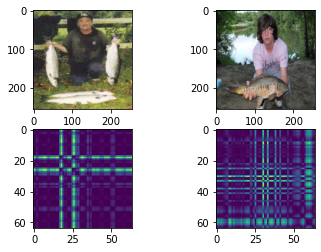

In [14]:
plt.subplot(221)
plt.imshow(ds_train[4][0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(ds_train[8][0].cpu().permute(1, 2, 0))

plt.subplot(223)
plt.imshow(ds_train[8][1][0][0])
plt.subplot(224)
plt.imshow(ds_train[4][1][0][0])

In [18]:
print(ds_train[0][1][1])
print(ds_train[1][1][1])

0
0


In [30]:
ds_train[0][1][0].shape

torch.Size([1, 64, 64])